<h1>🤖 MLAI Workshop #03</h1>

In the first workshop we explored the trade-offs between the hypothesis space, dataset, optimization and how it influenced the final solution using simple hand-crafted models

In the second workshop we put this into context and explored how we can design universal function approximators, and explore some of the challenges and limitations in learning from data

In [160]:
import torch

# observe some data using a noisy observation process
def observe_noisy(f, x):
  # Input noise ~ N(mean=0.05, std=0.02)
  x_noise = torch.randn_like(x) * 0.02 + 0.05
  x_measure = x + x_noise

   # Evaluate the (noisy) inputs
  y_pred = f(x_measure)

  # Output noise ~ N(mean=-0.05, std=0.08)
  y_noise = torch.randn_like(y_pred) * 0.08 - 0.05
  y_obs = y_pred + y_noise

  return y_obs

<h2>Section 1. Prior Section on Limitations</h2>



<h3>Section 1A. Summary of Workshop #2</h3>

First, let's define a dataset that holds our observations of the data generation process.

In [161]:
from typing import Callable

# create a dataset
class Dataset:
  def __init__(self, f: Callable, a: float, b: float, N: int = 100):
    super(Dataset, self).__init__()

    # Sample x uniformly in [a, b], shape [N,1]
    self.x = torch.rand(N, 1) * (b - a) + a

    # Observe f(x) through noise process, also [N,1]
    self.y = observe_noisy(f, self.x)

Let's define a specific function representing the data generating process:

\begin{align*}
  f^{*}(x) = e^{-x^{2}} sin(5.8\pi x + 0.41) \tag{1.1}
\end{align*}

And create a dataset using this function on the domain $x \in \left[0, 1\right]$


Text(0, 0.5, 'y_obs')

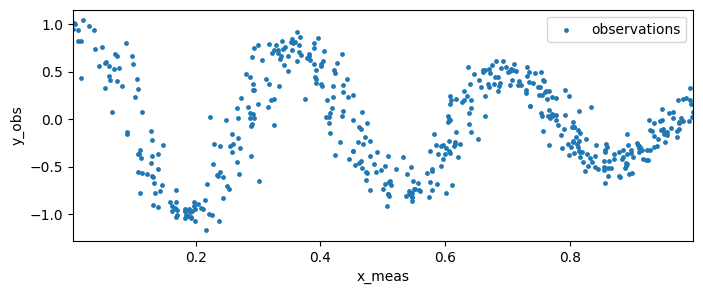

In [162]:
import matplotlib.pyplot as plt

# define a target function i.e. your data generating process
f = lambda x: torch.exp(-x**2) * torch.sin(5.8 * torch.pi * x + 0.41)

# define a dataset with your function
dataset = Dataset(f, 0, 1, 500)

# visualize the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(dataset.x, dataset.y, s=6, label="observations")
ax.set_xlim(dataset.x.min(), dataset.x.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

We assume we do not have access to the structure of $f^{*}$ and instead opt to build a flexible hypothesis space capable of learning to approximate other functions. We will use a multilayer perceptron with ReLU non-linear activation to enable our model to build abstract piecewise-affine approximations of arbitrary functions.

In [163]:
import torch.nn as nn

# create a flexible hypothesis space using an MLP
class PerceptronLayer(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, act: bool = True):
        super(PerceptronLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.act = nn.ReLU() if act else nn.Identity()

    def forward(self, x):
        x = self.act(self.fc(x))
        return x


class MultiLayerPerceptron(nn.Module):
    def __init__(self, hidden_layers: int = 0, hidden_dim: int = 1, input_dim: int = 1, output_dim: int = 1):
        super(MultiLayerPerceptron, self).__init__()

        # Create input layer
        modules = [PerceptronLayer(1, hidden_dim)]

        # Create hidden layers
        for _ in range(hidden_layers):
            modules.append(PerceptronLayer(hidden_dim, hidden_dim))

        # Create output layer
        modules.append(PerceptronLayer(hidden_dim, 1, act=False)) # just perform linear aggregation and no non-linearity

        # Create the model
        self.layers = nn.ModuleList(modules)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Let's define some helper functions to simplify the process of training this model.

In [164]:
from tqdm import tqdm

# define a training loop
def training_loop(model, optimizer, loss_fn, dataset, steps):
  losses = []
  with tqdm(range(steps)) as pbar:
    for idx in pbar:
      optimizer.zero_grad()
      y_pred = model(dataset.x)
      loss = loss_fn(dataset.y, y_pred)
      losses.append(loss)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"loss: {loss.item():.3f}")
    return model, torch.tensor(losses)

In [165]:
# define some functions for plotting our results
def plot_loss_curve(losses):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(losses, label="loss")
    ax.set_xlim(left=0, right=len(losses)-1)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss (MSE)")
    ax.set_title("Loss Curve")
    ax.grid(True, alpha=0.50)
    ax.legend()
    return fig, ax

def plot_predictions(model, dataset, ax = None):
    if ax is None: fig, ax = plt.subplots(figsize=(8,3))
    with torch.no_grad():
        ax.scatter(dataset.x, model(dataset.x), s=4, label="predictions")
        ax.scatter(dataset.x, dataset.y, s=4, label="observations")
    ax.set_xlim(left=dataset.x.min(), right=dataset.x.max())
    ax.grid(True, alpha=0.50)
    ax.legend(loc="best")
    return ax

Finally, lets train our model using these building blocks.

In [171]:
# train a model
dataset = Dataset(f, 0, 1, 500)
model = MultiLayerPerceptron(2, 50) # 0 hidden layers / 1 perceptrons
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, 500)

loss: 0.036: 100%|██████████| 500/500 [00:02<00:00, 217.71it/s]


We can explore how the different aspects of the machine learning problem: the hypothesis space $\mathcal{H}$ (MLP), the dataset $\mathcal{D}$ (observations), the optimizer $\mathcal{O}$ (Adam), and the the loss function $\mathcal{L}$ (MSE) impact the performance of the final model we obtain $\hat{f}$.

We can see that if our hypothesis space is too small we struggle to fit the dataset.

We can see that our dataset constrains how we learn.

And we can see that as out solution space becomes larger the optimizer often needs to be more robust at navigating the loss landscape.

<Axes: >

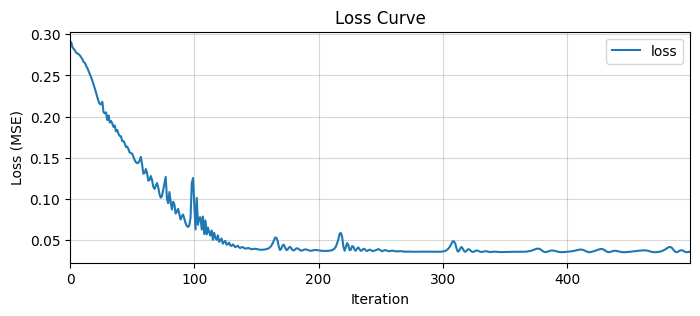

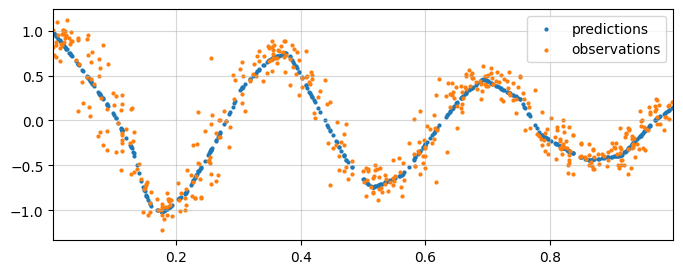

In [172]:
plot_loss_curve(losses)
plot_predictions(model, dataset)

<h3>Section 1B. How robust is our model?</h3>

We can evaluate how well this class of model interpolates and extrapolates across the data manifold to understand their generalization capabilities.

loss: 0.038: 100%|██████████| 500/500 [00:02<00:00, 241.30it/s]


(0.0, 1.0)

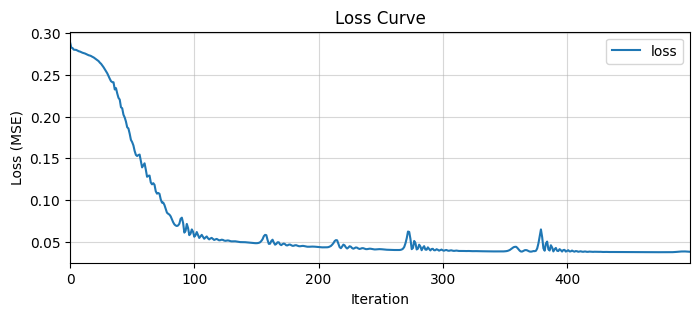

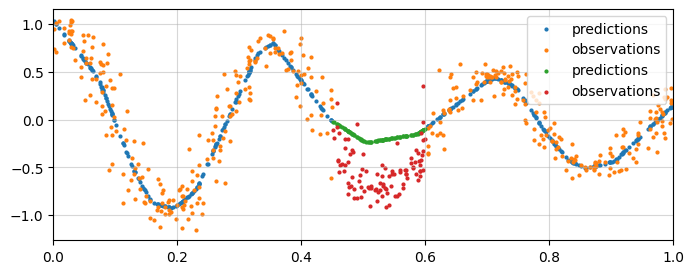

In [173]:
# define your domain
dataset = Dataset(f, 0, 1, 500)

# lets explore how well it interpolates by erasing a region
x_min, x_max = 0.45, 0.60
keep_idxs = (dataset.x < x_min) | (dataset.x > x_max)
dataset.x = dataset.x[keep_idxs].unsqueeze(-1)
dataset.y = dataset.y[keep_idxs].unsqueeze(-1)

# train a model
model = MultiLayerPerceptron(2, 40) # 0 hidden layers / 1 perceptrons
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, 500)

# plot the results
plot_loss_curve(losses)
ax = plot_predictions(model, dataset)

# see how well it interpolates
dataset_interp = Dataset(f, x_min, x_max, 100)
ax = plot_predictions(model, dataset_interp, ax)
ax.set_xlim(0, 1)

(-1.0, 2.0)

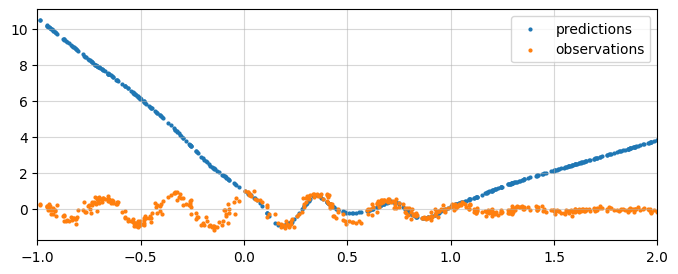

In [174]:
# define a much broader domain to see how well it extrapolates
dataset_extrap = Dataset(f, -1, 2, 500)

# plot the results
ax = plot_predictions(model, dataset_extrap)
ax.set_xlim(-1, 2)

<h3>Section 1C. Investigating the Model</h3>

We can investigate what these models are doing under the hood by exploring the activation across different neurons.

In [175]:
# lets explore the model
model

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): PerceptronLayer(
      (fc): Linear(in_features=1, out_features=40, bias=True)
      (act): ReLU()
    )
    (1-2): 2 x PerceptronLayer(
      (fc): Linear(in_features=40, out_features=40, bias=True)
      (act): ReLU()
    )
    (3): PerceptronLayer(
      (fc): Linear(in_features=40, out_features=1, bias=True)
      (act): Identity()
    )
  )
)

We can explore how a given Perceptron in the network activates.

In [176]:
# store
activations = {}

# define a forward pass hook to grab the outputs
def make_hook(name):
  def hook(module, input, output):
    # detach to avoid keeping the full graph
    activations[name] = output.detach().cpu()
  return hook

# register model hooks to the ReLU outputs
for idx, layer in enumerate(model.layers):
  if not layer.act._forward_hooks:
    layer.act.register_forward_hook(make_hook(f"layer_{idx}_relu"))

# run a forward pass on region to populate activations
x = torch.linspace(-1, 2, steps=1000).unsqueeze(-1)
_ = model(x)

(-1.0, 2.0)

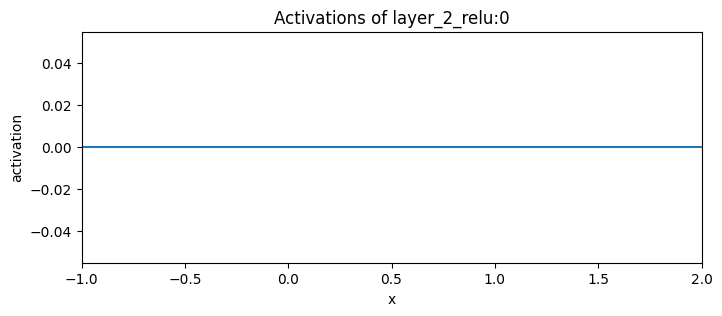

In [201]:
# which perceptron to inspect
layer_index = 2
perceptron_index = 0

# acts is of shape [N, output_dim]
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(x, activations[f"layer_{layer_index}_relu"][:,perceptron_index])
ax.set_title(f"Activations of layer_{layer_index}_relu:{perceptron_index}")
ax.set_xlabel("x")
ax.set_ylabel("activation")
ax.set_xlim(x.min(), x.max())

In [202]:
# explore the weights across different layers
layer_index = 2
perceptron_index = 4

#
layer = model.layers[layer_index]
weights = layer.fc.weight[perceptron_index].detach().cpu()
bias = layer.fc.bias[perceptron_index].detach().cpu()
print(f"W {weights.shape} = {weights}")
print(f"b {bias.shape} = {bias}")

W torch.Size([40]) = tensor([ 0.0558,  0.0665,  0.1151, -0.1164,  0.0712, -0.1127,  0.0953,  0.4158,
        -0.0453,  0.3356, -0.7302, -0.0059, -0.0614,  0.3691, -0.6339, -0.0277,
         0.2100,  0.0021, -0.0181,  0.1685, -0.0212, -0.3039, -0.5058,  0.0631,
        -0.2082,  0.0104, -0.1318,  0.0738, -0.0525, -0.1219,  0.0345,  0.2525,
         0.1420, -0.3417,  0.1887, -0.8971,  0.0404, -0.0457,  0.0149,  0.1699])
b torch.Size([]) = -0.04581945762038231


Visually inspecting the weights and biases of these networks becomes increasingly difficult to interpret, but we can see the network is learning increasingly more complex and abstract piecewise-affine approximations.

Polynomial error interpolation, bounded by how much the data resolves the change

<h2>Section 2. Using our model to perform classification</h2>

We've been simply attempting to learn a function, while this is useful, we've been working off the assumption we have a function. Let's explore a slightly more abstract concept

In [203]:
# define a dataset
from typing import Callable

# create a dataset
class Dataset:
  def __init__(self, f: Callable, a: float, b: float, N: int = 100):
    super(Dataset, self).__init__()

    # Sample x uniformly in [a, b], shape [N,1]
    self.x = torch.rand(N, 1) * (b - a) + a

    # Observe f(x) through noise process, also [N,1]
    self.y = observe_noisy(f, self.x)

    # Assign y to a specific label
    self.y[self.y >= 0.25] = 1.
    self.y[self.y < 0.25] = .0

Text(0, 0.5, 'y_obs')

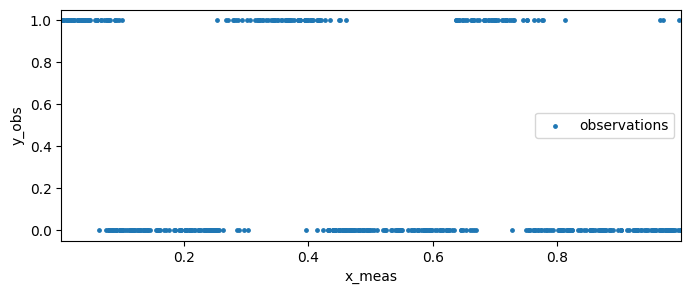

In [205]:
#
dataset = Dataset(f, 0, 1, 500)

# visualize the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(dataset.x, dataset.y, s=6, label="observations")
ax.set_xlim(dataset.x.min(), dataset.x.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

In [214]:
# train a model
model = MultiLayerPerceptron(4, 100) # 0 hidden layers / 1 perceptrons
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, 1000)

loss: 36.390:   0%|          | 1/1000 [00:00<01:43,  9.62it/s]


RuntimeError: all elements of target should be between 0 and 1

<Axes: >

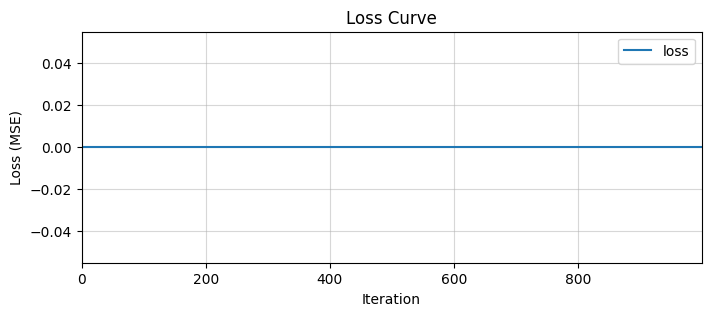

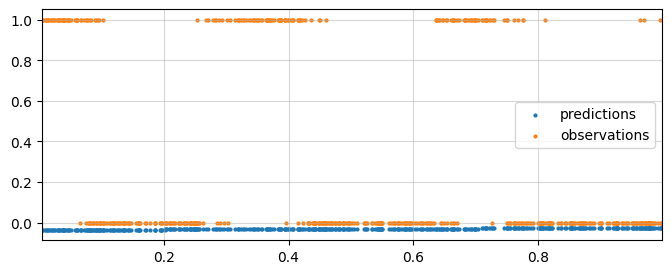

In [213]:
plot_loss_curve(losses)
plot_predictions(model, dataset)

<h2>Section 2. Multi-dimensional Functions</h2>

We've explored how we can apply machine learning to model a function if we have 1d input and some of the pitfalls that occur, however most data isn't 1d, multiple input features. etc.

We call what we've been doing so far shallow learning

lets explore applying ML to some more complex functions by building on our prior work.

In [ ]:
# input dimensions

What are high dimensional inputs and spaces, what do we mean by the term manifold.

In [ ]:
# manifolds

Lets define a dataset

In [ ]:
# define dataset

In [ ]:
# visualize dataset

Lets definea model

In [ ]:
# construct a model

Lets train a model

In [ ]:
# train a model

Evaluate a model

In [ ]:
# evaluate interpolation on complete data

In [ ]:
# evaluate interpolation on incomplete dta

In [ ]:
# evaluate extrapolation

<h2>Section 3. High-dimensional Inputs</h3>

images

In [ ]:
# what is an image ; an arangement of pixels

In [ ]:
# can treat as a 1d input

lets define a dataset

In [ ]:
# define a dataset

lets define a model

In [ ]:
# define a model

train the model

In [ ]:
# train the model

evaluate the model

discuss the trade-offs between inductive biases such as cnns which are restrictive but enable dataset efficiency as opposed to transformers